---
# Please don't change the text below, it's for formatting the documentation.
title: "Fully Fine-tune a Small Language Model with Hugging Face Tutorial"
description: "Learn how to fully fine-tune a Small Language Model on a custom dataset with Hugging Face Transformers."
image: "https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/00-project-food-not-food-overview.png"
format: 
  html:
    code-fold: false
    page-layout: full
jupyter: python3
number-sections: true
toc: true
toc-depth: 3
toc-expand: 2 # expand toc to multiple levels
code-block-border-left: true
code-block-bg: true
---

Why fine-tune?

Because we want small model for a specific task (e.g. don't to pay API credits or leak our data online).

If we have our own model... we can run it anywhere and everywhere we like.

## How to fine-tune an LLM model

We are going to do Supervised Fine-tuning (SFT). 

Basically SFT = give samples of inputs and outputs.

For example if our goal was to extract names: 

- Input: Hello my name is Daniel
- Output: Daniel

Note:

* Our inputs can be *any* kind of input string.
* Our outputs will be fine-tuned to conform to a structured data pattern.

## What we're cooking

We're going to build a SLM (Small Language Model) to extract food and drink items from text.

Why?

If we needed to go over a large dataset of image captions and filter them for food items (we could then use these filtered captions for a food app).

TK image - example of what we're doing.

## Ingredients

1. Model (Gemma3-270M)
2. Dataset (a pre-baked dataset to extract foods from text)
3. Training code (Hugging Face Transformers + TRL)
4. Eval code
5. Demo

## Method

1. Download model - Hugging Face `transformers`
2. Download dataset - Hugging Face `datasets`
3. Inspect dataset - Hugging Face `datasets` 
4. Train model on dataset - Hugging Face `trl` (TRL = Transformers Reinforcement Learning)
5. Eval model - basically just look at a bunch of samples
6. Create an interactive demo - Hugging Face `gradio` 
7. Bonus: Make the demo public so other people can use it - Hugging Face Spaces

## Fine-tuning LLM vs RAG

* Fine-tuning = To do a very specific task, e.g. structured data extraction.
    * An example would be you're an insurance company who gets 10,000 emails a day and you want to extract structured data directly from these emails to JSON.
* RAG = You want to inject custom knowledge into an LLM.
    * An example would be you're an insurance company wanting to send *automatic* responses to people but you want the responses to include information from your own docs.

## Why fine-tune your own model?

1. Own the model, can run on own hardware
2. Our task is simple enough to just use a small language model
3. No API calls needed 
4. Can run in batch mode to get much faster inference than API calls
5. Model by default wasn't very good at our task but now since fine-tuning, is *very good* 

## Definitions

* TK - Some definitions of what we're doing
* Full fine-tuning
* LORA fine-tuning (this is partial fine-tuning)
* SLM

## Import dependencies



In [ ]:
import transformers 
import trl # trl = Transformers Reinforcement Learning -> https://github.com/huggingface/trl 
import datasets 
import acclerate

import gradio as gr

## Setup Base Model 

The base model we'll be using is [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m-it/tree/main) from Google.

It's the same architecture style as larger LLMs such as Gemini but at a *much* smaller scale.

This is why we refer to it as a "Small Language Model" or SLM.

We can load our model using `transformers`.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "google/gemma-3-270m-it" # note: "it" stands for "instruction tuned" which means the model has been tuned for following instructions

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype="auto",
    device_map="auto", # put the model on the GPU
    attn_implementation="eager" # could use flash_attention_2 but ran into issues... so stick with Eager for now
)

/home/mrdbourke/miniforge3/envs/ai/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


In [2]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"[INFO] Model on device: {model.device}")
print(f"[INFO] Model using dtype: {model.dtype}")

[INFO] Model on device: cuda:0
[INFO] Model using dtype: torch.bfloat16


In [ ]:
# # Our model requires numbers (tokens) as input
# # We can turn strings into tokens via a tokenizer!
# model("Hello my name is Daniel")

In [4]:
tokenizer("Hello my name is Daniel")

{'input_ids': [2, 9259, 1041, 1463, 563, 13108], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [3]:
import torch 

outputs = model(torch.tensor(tokenizer("Hello my name is Daniel")["input_ids"]).unsqueeze(0).to("cuda"))
outputs.keys()

odict_keys(['logits', 'past_key_values'])

## Get dataset

TK - our dataset is located here: (link), it was created from image captions + random strings and then using `gpt-oss-120b` (a powerful open-source LLM) to do synthetic labelling

In [5]:
from datasets import load_dataset

dataset = load_dataset("mrdbourke/FoodExtract-1k")

print(f"[INFO] Number of samples in the dataset: {len(dataset['train'])}")

[INFO] Number of samples in the dataset: 1420


In [6]:
import random

def get_random_idx(dataset):
    """Returns a random integer index based on the number of samples in the dataset."""
    random_idx = random.randint(0, len(dataset)-1)
    return random_idx


random_idx = get_random_idx(dataset["train"])
random_sample = dataset["train"][random_idx]

import json

example_input = random_sample["sequence"]
example_output = random_sample["gpt-oss-120b-label"]
example_output_condensed = random_sample["gpt-oss-120b-label-condensed"]

print(f"[INFO] Input:\n{example_input}")
print()
print(f"[INFO] Example output:")
print(eval(example_output))
print()
print(f"[INFO] Example output condensed:")
print(example_output_condensed)

[INFO] Input:
the building where the resort village is located

[INFO] Example output:
{'is_food_or_drink': False, 'tags': [], 'food_items': [], 'drink_items': []}

[INFO] Example output condensed:
food_or_drink: 0
tags: 
foods: 
drinks:


### Format the dataset into LLM-style inputs/outputs

Right now we have examples of string-based inputs and structured outputs.

However, our LLMs generally want things in the format of: 

```
{"user": "Hello my name is Daniel",
"system": "Hi Daniel, I'm an LLM"}
```

In other words, they want structure around the intputs and outputs rather than just raw information.

> **Resource:** See the dataset formats and types in the TRL docs: https://huggingface.co/docs/trl/en/dataset_formats 

In [7]:
random_sample

{'sequence': 'the building where the resort village is located',
 'image_url': 'https://q-cf.bstatic.com/images/hotel/max1024x768/216/216309766.jpg',
 'class_label': 'not_food',
 'source': 'qwen2vl_open_dataset',
 'char_len': 48.0,
 'word_count': 8.0,
 'syn_or_real': 'real',
 'uuid': '2842f35d-ad79-4024-a063-e16987a6896a',
 'gpt-oss-120b-label': "{'is_food_or_drink': False, 'tags': [], 'food_items': [], 'drink_items': []}",
 'gpt-oss-120b-label-condensed': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:',
 'target_food_names_to_use': None,
 'caption_detail_level': None,
 'num_foods': None,
 'target_image_point_of_view': None}

In [8]:
def sample_to_conversation(sample):
    return {
        "messages": [
            {"role": "user", "content": sample["sequence"]}, # Load the sequence from the dataset
            {"role": "system", "content": sample["gpt-oss-120b-label-condensed"]} # Load the gpt-oss-120b generated label
        ]
    }

sample_to_conversation(random_sample)

{'messages': [{'role': 'user',
   'content': 'the building where the resort village is located'},
  {'role': 'system', 'content': 'food_or_drink: 0\ntags: \nfoods: \ndrinks:'}]}

In [9]:
# Map our sample_to_conversation function to dataset 
dataset = dataset.map(sample_to_conversation,
                      batched=False)

dataset["train"][0]

{'sequence': 'A mouth-watering photograph captures a delectable dish centered on a rectangular white porcelain plate, resting on a rustic wooden tabletop indoors. In the background, a wooden cutting board with a long handle subtly enhances the setting. The plate is adorned with several generously-sized, cheese-stuffed peppers that have been roasted to perfection, their blistered skins marked by charred black spots. Split down the middle, the peppers reveal a creamy white cheese filling, enriched with a blend of aromatic herbs. Once stuffed, the peppers have been closed and roasted, achieving a luscious, smoky flavor.\n\nThe dish is elegantly garnished with vibrant cherry tomato halves, freshly chopped green herbs, and delicate sprinkles of small diced red onions. A light, possibly citrus-infused dressing, hinted by a sheen of oil or lime juice, gently coats the ensemble, adding an extra layer of freshness. The meticulous presentation and vivid colors make this image not only a feast fo

In [10]:
# Create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2,
                                            shuffle=False,
                                            seed=42)

# Number #1 rule in machine learning
# Always train on the train set and test on the test set
# This gives us an indication of how our model will perform in the real world
dataset

DatasetDict({
    train: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 1136
    })
    test: Dataset({
        features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
        num_rows: 284
    })
})

### Try the model with a pipeline

In [11]:
easy_sample = {"role": "user", "content": "Hi my name is Daniel"}

def create_easy_sample(input):
    template = {"role": "user", "content": input}
    return template


In [14]:
from transformers import pipeline 

# Load model and use it as a pipeline
pipe = pipeline("text-generation",
                model=model,
                tokenizer=tokenizer)

input_text = "Hi my name is Daniel. Please reply to me with a machine learning poem."
easy_sample = create_easy_sample(input=input_text)
input_prompt = pipe.tokenizer.apply_chat_template([easy_sample],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

print(f"[INFO] This is the input prompt: {input_prompt}")

default_outputs = pipe(input_prompt,
                       max_new_tokens=512,
                       disable_compile=True)

print(f"[INFO] Input:\n{input_text}")
print()
print(f"[INFO] Output from {MODEL_NAME}:")
print()
print(default_outputs[0]["generated_text"][len(input_prompt):])

Device set to use cuda:0


[INFO] This is the input prompt: <bos><start_of_turn>user
Hi my name is Daniel. Please reply to me with a machine learning poem.<end_of_turn>
<start_of_turn>model

[INFO] Input:
Hi my name is Daniel. Please reply to me with a machine learning poem.

[INFO] Output from google/gemma-3-270m-it:

Okay, Daniel, here's a machine learning poem. I've tried to capture a feeling of wonder and a bit of mystery.

The algorithm learns,
A silent, tireless quest.
Through data streams, it flows,
A symphony of thought.
Each point a new layer,
A learning bloom,
A future bright and clear.

It analyzes the data,
No single clue it knows.
It weaves a pattern true,
A story in the hue.
The world unfolds anew,
With subtle, complex view.

It's not just numbers,
But feeling, a soul.
A tapestry of grace,
A hopeful, vibrant space.
A learning, growing deep,
Secrets it will keep.



Example machine learning poem generated by Gemma 3 270M:

```
Okay, Daniel, here's a machine learning poem. I've tried to capture a feeling of wonder and a bit of mystery.

The algorithm learns,
A silent, tireless quest.
Through data streams, it flows,
A symphony of thought.
Each point a new layer,
A learning bloom,
A future bright and clear.

It analyzes the data,
No single clue it knows.
It weaves a pattern true,
A story in the hue.
The world unfolds anew,
With subtle, complex view.

It's not just numbers,
But feeling, a soul.
A tapestry of grace,
A hopeful, vibrant space.
A learning, growing deep,
Secrets it will keep.
```

### Try the model on one of our sequences

In [98]:
# Get a random sample
random_idx = get_random_idx(dataset["train"])
random_train_sample = dataset["train"][random_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_train_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
A top‑down view of a rustic wooden board featuring three distinct elements: a mound of peeled white yams, sliced into thick, ivory‑colored rounds that show a smooth, slightly creamy interior; a small ceramic bowl of deep‑red gochujang, its glossy surface speckled with tiny black pepper flecks; and a tray of golden‑brown empanadas, their flaky pastry crust lightly brushed with a sheen of butter and dotted with a few crisp, baked edges. The items are spaced apart, each highlighted against the neutral board, emphasizing their individual textures and colors.<end_of_turn>
<start_of_turn>model


[INFO] Output:
This is a great description of the rustic wooden board! It effectively conveys the following:

* **Overall Impression:** The board is a rustic and inviting space, emphasizing a warm and inviting atmosphere.
* **Key Elements:** The key elements are the mound of peeled white yams, sliced into thick rounds, the smooth, creamy interior, the deep-red g

### Let's try to prompt the model

We want a model to extract food and drink items from text.

By default the model will just reply to any text input.

However, we can try and get our ideal outputs via prompting.

In [112]:
prompt_instruction = """Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Target input text: <targ_input_text>"""

def update_input_message_content(input):
    original_content = input["messages"][:1][0]["content"]
    new_content = prompt_instruction.replace("<targ_input_text>", original_content)

    new_input = [{"content": new_content,
                  "role": "user"}]
    
    return new_input

print(f'[INFO] Original content:\n{random_train_sample["messages"][:1][0]["content"]}')
print()
print(f'[INFO] New content with instructions in prompt:')
print(update_input_message_content(input=random_train_sample)[0]["content"])

[INFO] Original content:
A top‑down view of a rustic wooden board featuring three distinct elements: a mound of peeled white yams, sliced into thick, ivory‑colored rounds that show a smooth, slightly creamy interior; a small ceramic bowl of deep‑red gochujang, its glossy surface speckled with tiny black pepper flecks; and a tray of golden‑brown empanadas, their flaky pastry crust lightly brushed with a sheen of butter and dotted with a few crisp, baked edges. The items are spaced apart, each highlighted against the neutral board, emphasizing their individual textures and colors.

[INFO] New content with instructions in prompt:
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Ex

In [113]:
# Apply the chat template
updated_input_prompt = update_input_message_content(input=random_train_sample)

input_prompt = pipe.tokenizer.apply_chat_template(conversation=updated_input_prompt,
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = pipe(text_inputs=input_prompt, 
                       max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
Given the following target input text from an image caption, please extract the food and drink items to a list. 
If there are no food or drink items, return an empty list.

Return in the following format:
food_items: [item_1, item_2, item_3]
drink_items: [item_4, item_5]

For example:
Input text: Hello my name is Daniel.
Output:
food_items: []
drink_items: []

Example 2:
Input text: A plate of rice cakes, salmon, cottage cheese and small cherry tomatoes with a cup of tea.
Output:
food_items: ['rice cakes', 'salmon', 'cottage cheese', 'cherry tomatoes']
drink_items: ['cup of tea']

Target input text: A top‑down view of a rustic wooden board featuring three distinct elements: a mound of peeled white yams, sliced into thick, ivory‑colored rounds that show a smooth, slightly creamy interior; a small ceramic bowl of deep‑red gochujang, its glossy surface speckled with tiny black pepper flecks; and a tray of golden‑brown empanadas, their flaky pastry cr

In [121]:
# This is our input
print(random_train_sample["messages"][0]["content"])
print()

# This is our ideal output: 
print(random_train_sample["messages"][1]["content"])

A top‑down view of a rustic wooden board featuring three distinct elements: a mound of peeled white yams, sliced into thick, ivory‑colored rounds that show a smooth, slightly creamy interior; a small ceramic bowl of deep‑red gochujang, its glossy surface speckled with tiny black pepper flecks; and a tray of golden‑brown empanadas, their flaky pastry crust lightly brushed with a sheen of butter and dotted with a few crisp, baked edges. The items are spaced apart, each highlighted against the neutral board, emphasizing their individual textures and colors.

food_or_drink: 1
tags: fi
foods: peeled white yams, deep-red gochujang, golden-brown empanadas
drinks:


Okay looks like our small LLM doesn't do what we want it to do... no matter, we can fine-tune it so it does our specific task!

## Fine-tuning our model

Steps:

1. Setup SFTConfig (Supervised Fine-tuning Config) - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTConfig 
2. Use SFTTrainer to train our model on our supervised samples - https://huggingface.co/docs/trl/v0.26.2/en/sft_trainer#trl.SFTTrainer 

In [123]:
# Setting up our SFTConfig
from trl import SFTConfig

torch_dtype = model.dtype

CHECKPOINT_DIR_NAME = "./checkpoint_models"
BASE_LEARNING_RATE = 5e-5

print(f"[INFO] Using dtype: {torch_dtype}")
print(f"[INFO] Using learning rate: {BASE_LEARNING_RATE}")

sft_config = SFTConfig(
    output_dir=CHECKPOINT_DIR_NAME,
    max_length=512,
    packing=False,
    num_train_epochs=3,
    per_device_train_batch_size=16, # Note: you can change this depending on the amount of VRAM your GPU has
    per_device_eval_batch_size=16,
    gradient_checkpointing=False,
    optim="adamw_torch_fused", # Note: if you try "adamw", you will get an error
    logging_steps=1,
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=BASE_LEARNING_RATE,
    fp16=True if torch_dtype == torch.float16 else False,
    bf16=True if torch_dtype == torch.float16 else False,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to=None
)

sft_config


[INFO] Using dtype: torch.bfloat16
[INFO] Using learning rate: 5e-05


SFTConfig(output_dir='./checkpoint_models', overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, eval_strategy=<IntervalStrategy.EPOCH: 'epoch'>, prediction_loss_only=False, per_device_train_batch_size=16, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=5e-05, weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3, max_steps=-1, lr_scheduler_type=<SchedulerType.CONSTANT: 'constant'>, lr_scheduler_kwargs=None, warmup_ratio=0.0, warmup_steps=0, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='./checkpoint_models/runs/Jan07_00-53-16_spark-ff62', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=1, logging_nan_inf_filter=True, save_strategy=<SaveStrategy.EPOCH: 'epoch'>, save_

In [124]:
# Supervised Fine-Tuning = provide input and desired output samples
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer 
)

trainer.train()

Tokenizing train dataset:   0%|          | 0/908 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/908 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/228 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/228 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,2.226700,2.081992,1.969289,123023.000000,0.604268
2,1.911500,2.040673,1.757004,246046.000000,0.611950
3,1.278400,2.101415,1.560075,369069.000000,0.612939


TrainOutput(global_step=171, training_loss=2.0012289899134497, metrics={'train_runtime': 229.1573, 'train_samples_per_second': 11.887, 'train_steps_per_second': 0.746, 'total_flos': 630811463417856.0, 'train_loss': 2.0012289899134497, 'epoch': 3.0})

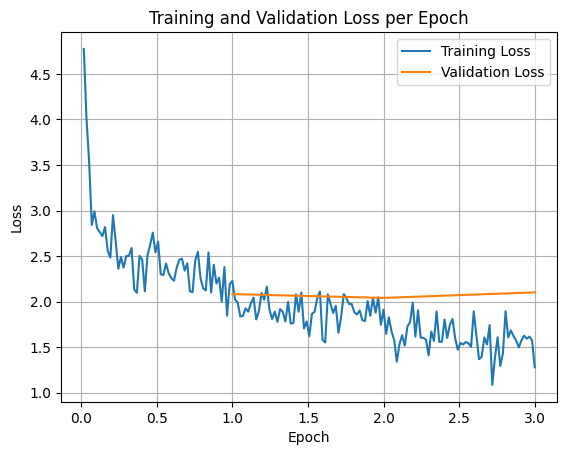

In [126]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
tags_dict = {'np': 'nutrition_panel',
 'il': 'ingredient list',
 'me': 'menu',
 're': 'recipe',
 'fi': 'food_items',
 'di': 'drink_items',
 'fa': 'food_advertistment',
 'fp': 'food_packaging'}

In [127]:
# Save the model
trainer.save_model()

## Load the trained model back in and see how it performs

We've now fine-tuned our own Gemma 3 270M to do a specific task, let's load it back in and see how it performs.

In [128]:
CHECKPOINT_DIR_NAME

'./checkpoint_models'

In [133]:
# Load the fine-tuned model and see how it goes
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load trained model
loaded_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=CHECKPOINT_DIR_NAME,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
);



In [134]:
loaded_model_pipeline = pipeline("text-generation",
                                 model=loaded_model,
                                 tokenizer=tokenizer)

loaded_model_pipeline

Device set to use cuda:0


In [161]:
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 228
})

In [160]:
# Get a random sample
random_test_idx = get_random_idx(dataset["test"])
random_test_sample = dataset["test"][random_test_idx]

# Apply the chat template
input_prompt = pipe.tokenizer.apply_chat_template(conversation=random_test_sample["messages"][:1],
                                                  tokenize=False,
                                                  add_generation_prompt=True)

# Let's run the default model on our input
default_outputs = loaded_model_pipeline(text_inputs=input_prompt, 
                                        max_new_tokens=256)

# View and compare the outputs
print(f"[INFO] Input:\n{input_prompt}\n")
print(f"[INFO] Output:\n{default_outputs[0]['generated_text'][len(input_prompt):]}")

[INFO] Input:
<bos><start_of_turn>user
The image shows a box of Arnott's Flavoured Biscuits. The ingredients list includes Wheat Flour, Vegetable Oil (Antioxidant E307b from Soy), Tomato Powder, Starch (Wheat), Salt, Yeast, Garlic Powder, Parsley, Sugar, Worcestershire Sauce, Natural Flavour, Onion Powder, Baking Powder, Spices, Spice Extracts, Vegetable Protein Extract (from Maize), Antioxidant (E300), Flavour Enhancer (E635), Malt Extract (from Barley), and Emulsifier (Soy Lecithin). The box also states that it contains Wheat, Gluten, Soy, and may contain Egg, Milk, Tree Nuts, Peanut, and Sesame. The nutritional information section is partially visible, listing servings, energy, protein, fat, total carbohydrates, sugars, dietary fibre, and sodium. The brand name Arnott's Australia is prominently displayed, along with the tagline "Exporting to the World." The box is green with red and white accents.<end_of_turn>
<start_of_turn>model


[INFO] Output:
food_or_drink: 1
tags: np, fi, fp, 

In [150]:
print(random_test_sample["gpt-oss-120b-label-condensed"])

food_or_drink: 1
tags: np, il, fp, fi, di
foods: mushroom, lemongrass, galangal, chili, soybean oil, garlic, shallot, kaffir lime leaves, fish sauce, parsley, pepper, fish, crustacean, egg, peanut, soy, sesame, cashew
drinks: water, lime juice


In [131]:
dataset["train"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 908
})

In [159]:
# Eval on these
dataset["test"]

Dataset({
    features: ['sequence', 'image_url', 'class_label', 'source', 'char_len', 'word_count', 'syn_or_real', 'uuid', 'gpt-oss-120b-label', 'gpt-oss-120b-label-condensed', 'target_food_names_to_use', 'caption_detail_level', 'num_foods', 'target_image_point_of_view', 'messages'],
    num_rows: 228
})

In [152]:
def get_model_num_params(model):
    """
    Returns the number of trainable, non-trainable and total parameters of a PyTorch model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_params = trainable_params + non_trainable_params
    return {"trainable_params": trainable_params,
            "non_trainable_params": non_trainable_params,
            "total_params": total_params}

# Get parameters of our fine-tuned model
model_params = get_model_num_params(loaded_model)
print(f"Trainable parameters: {model_params['trainable_params']:,}")
print(f"Non-trainable parameters: {model_params['non_trainable_params']:,}")
print(f"Total parameters: {model_params['total_params']:,}")

Trainable parameters: 268,098,176
Non-trainable parameters: 0
Total parameters: 268,098,176


In [153]:
# Our model is 270M parameters, GPT-OSS-120B is 120B parameters

In [154]:
120_000_000_000 / 270_000_000

444.44444444444446

## Turning out model into a demo

In [162]:
import gradio as gr

ModuleNotFoundError: No module named 'gradio'

In [ ]:
# Reminder:
# Input = text of image caption
# Output = structured data
# LLMs = tokens in, tokens out -> if you get the right tokens in, you'll get the right tokens out